In [1]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url) #"f0f1f7dd1347fcf27e44809445f54f42"

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  basanikhilesh


Your Kaggle Key:

  ································


100%|██████████| 395M/395M [00:10<00:00, 39.4MB/s] 


In [2]:
import os
DATA_DIR = './animefacedataset'

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

image_size = 64
batch_size = 150
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


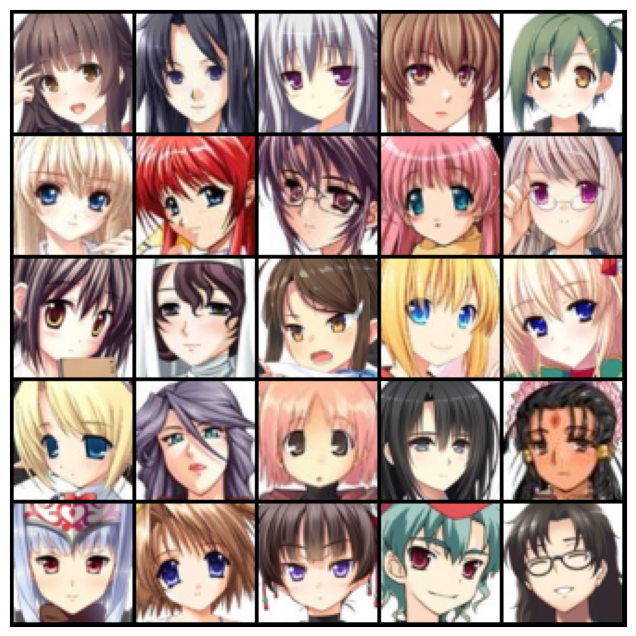

In [3]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=25):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([]) # nrow defines number of images to display in each row
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=5).permute(1, 2, 0))

def show_batch(dl, nmax=25):
    for images, _ in dl:
        show_images(images, nmax)
        break
        
show_batch(train_dl)

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
device

device(type='cuda')

In [6]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [7]:
discriminator = to_device(discriminator, device)

In [8]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([150, 3, 64, 64])


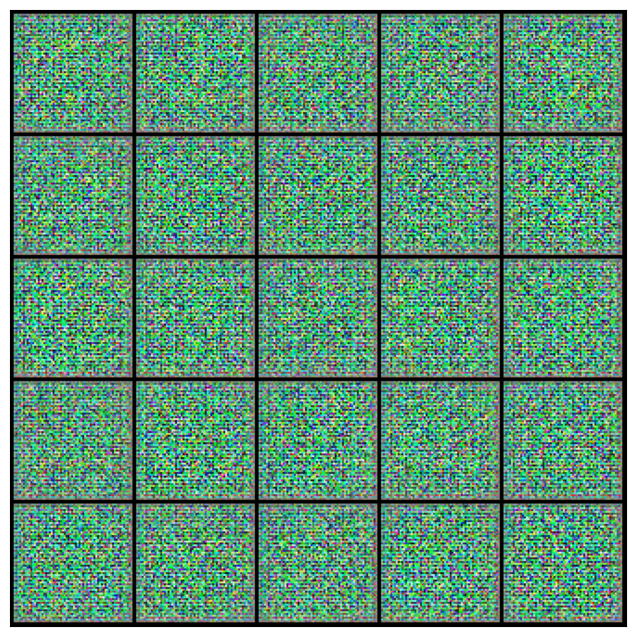

In [9]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images) #Let's see how a generator produces an image

In [10]:
generator = to_device(generator, device)

In [14]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [27]:
from torchvision.utils import save_image

sample_dir = '/kaggle/working'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'Generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=5).permute(1, 2, 0))

In [16]:
fixed_latent = torch.randn(150, latent_size, 1, 1, device=device)

In [17]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False) # Image rendering in saved files depends on number of latent tensors passed to generator
    
    return losses_g, losses_d, real_scores, fake_scores

In [18]:
lr = 0.0001
epochs = 100

history = fit(epochs, lr)

  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 6.4759, loss_d: 0.5311, real_score: 0.9465, fake_score: 0.3130
Saving Generated-images-0001.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 4.8325, loss_d: 0.3251, real_score: 0.9151, fake_score: 0.1895
Saving Generated-images-0002.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 8.3257, loss_d: 0.5851, real_score: 0.9467, fake_score: 0.3755
Saving Generated-images-0003.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 3.4144, loss_d: 0.3092, real_score: 0.8009, fake_score: 0.0147
Saving Generated-images-0004.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 4.7677, loss_d: 0.2300, real_score: 0.8437, fake_score: 0.0206
Saving Generated-images-0005.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.3452, loss_d: 0.2101, real_score: 0.9215, fake_score: 0.1081
Saving Generated-images-0006.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 4.7808, loss_d: 0.1834, real_score: 0.8678, fake_score: 0.0182
Saving Generated-images-0007.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 5.9416, loss_d: 0.2744, real_score: 0.9732, fake_score: 0.2022
Saving Generated-images-0008.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 3.2962, loss_d: 0.1942, real_score: 0.8606, fake_score: 0.0170
Saving Generated-images-0009.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.8683, loss_d: 0.1989, real_score: 0.8941, fake_score: 0.0474
Saving Generated-images-0010.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 8.7131, loss_d: 0.3339, real_score: 0.9955, fake_score: 0.2073
Saving Generated-images-0011.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.7324, loss_d: 0.1618, real_score: 0.8775, fake_score: 0.0145
Saving Generated-images-0012.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 2.8278, loss_d: 0.5061, real_score: 0.7046, fake_score: 0.0179
Saving Generated-images-0013.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 6.1046, loss_d: 0.0952, real_score: 0.9237, fake_score: 0.0108
Saving Generated-images-0014.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.5181, loss_d: 0.1991, real_score: 0.8759, fake_score: 0.0441
Saving Generated-images-0015.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 4.3389, loss_d: 0.1500, real_score: 0.9296, fake_score: 0.0662
Saving Generated-images-0016.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 4.1185, loss_d: 0.1183, real_score: 0.9295, fake_score: 0.0346
Saving Generated-images-0017.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 4.6310, loss_d: 0.0627, real_score: 0.9695, fake_score: 0.0294
Saving Generated-images-0018.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 4.1468, loss_d: 0.0932, real_score: 0.9282, fake_score: 0.0099
Saving Generated-images-0019.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.9183, loss_d: 0.0961, real_score: 0.9355, fake_score: 0.0159
Saving Generated-images-0020.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 4.9621, loss_d: 0.0597, real_score: 0.9551, fake_score: 0.0090
Saving Generated-images-0021.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 1.9125, loss_d: 0.3793, real_score: 0.7395, fake_score: 0.0031
Saving Generated-images-0022.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 3.5751, loss_d: 0.1191, real_score: 0.9345, fake_score: 0.0398
Saving Generated-images-0023.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 5.9796, loss_d: 0.1821, real_score: 0.9747, fake_score: 0.1279
Saving Generated-images-0024.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 6.1874, loss_d: 0.1268, real_score: 0.9818, fake_score: 0.0911
Saving Generated-images-0025.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 3.8509, loss_d: 0.0994, real_score: 0.9470, fake_score: 0.0332
Saving Generated-images-0026.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.6410, loss_d: 0.0946, real_score: 0.9398, fake_score: 0.0242
Saving Generated-images-0027.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 4.6626, loss_d: 0.0491, real_score: 0.9761, fake_score: 0.0231
Saving Generated-images-0028.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 5.0524, loss_d: 0.0620, real_score: 0.9713, fake_score: 0.0279
Saving Generated-images-0029.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.3469, loss_d: 0.1105, real_score: 0.9237, fake_score: 0.0186
Saving Generated-images-0030.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.2171, loss_d: 0.0345, real_score: 0.9814, fake_score: 0.0142
Saving Generated-images-0031.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.9969, loss_d: 0.0838, real_score: 0.9620, fake_score: 0.0282
Saving Generated-images-0032.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.7020, loss_d: 0.1124, real_score: 0.9267, fake_score: 0.0138
Saving Generated-images-0033.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 5.3946, loss_d: 0.0488, real_score: 0.9854, fake_score: 0.0300
Saving Generated-images-0034.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 5.2823, loss_d: 0.0495, real_score: 0.9750, fake_score: 0.0218
Saving Generated-images-0035.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 9.2004, loss_d: 0.2902, real_score: 0.9887, fake_score: 0.1998
Saving Generated-images-0036.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 6.6934, loss_d: 0.1546, real_score: 0.9759, fake_score: 0.1096
Saving Generated-images-0037.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 5.3054, loss_d: 0.1334, real_score: 0.8981, fake_score: 0.0031
Saving Generated-images-0038.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 5.1138, loss_d: 0.0801, real_score: 0.9587, fake_score: 0.0314
Saving Generated-images-0039.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 6.0343, loss_d: 0.0448, real_score: 0.9645, fake_score: 0.0057
Saving Generated-images-0040.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.4838, loss_d: 0.2830, real_score: 0.8992, fake_score: 0.1143
Saving Generated-images-0041.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 4.7181, loss_d: 0.0791, real_score: 0.9428, fake_score: 0.0127
Saving Generated-images-0042.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 8.4621, loss_d: 0.1898, real_score: 0.9944, fake_score: 0.1436
Saving Generated-images-0043.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 5.3326, loss_d: 0.0527, real_score: 0.9700, fake_score: 0.0177
Saving Generated-images-0044.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 6.9002, loss_d: 0.0250, real_score: 0.9879, fake_score: 0.0103
Saving Generated-images-0045.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 5.3932, loss_d: 0.0520, real_score: 0.9857, fake_score: 0.0351
Saving Generated-images-0046.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 4.8216, loss_d: 0.1143, real_score: 0.9448, fake_score: 0.0477
Saving Generated-images-0047.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 5.6362, loss_d: 0.0534, real_score: 0.9741, fake_score: 0.0234
Saving Generated-images-0048.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.4890, loss_d: 0.0407, real_score: 0.9718, fake_score: 0.0101
Saving Generated-images-0049.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.5840, loss_d: 0.0910, real_score: 0.9437, fake_score: 0.0262
Saving Generated-images-0050.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 4.8651, loss_d: 0.0479, real_score: 0.9849, fake_score: 0.0306
Saving Generated-images-0051.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 5.6338, loss_d: 0.0464, real_score: 0.9691, fake_score: 0.0125
Saving Generated-images-0052.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 5.0755, loss_d: 0.0583, real_score: 0.9973, fake_score: 0.0508
Saving Generated-images-0053.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.5476, loss_d: 0.1122, real_score: 0.9117, fake_score: 0.0014
Saving Generated-images-0054.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 4.0436, loss_d: 0.0681, real_score: 0.9555, fake_score: 0.0195
Saving Generated-images-0055.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 4.8117, loss_d: 0.0759, real_score: 0.9484, fake_score: 0.0187
Saving Generated-images-0056.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 6.7753, loss_d: 0.0998, real_score: 0.9802, fake_score: 0.0722
Saving Generated-images-0057.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.5690, loss_d: 0.0588, real_score: 0.9627, fake_score: 0.0169
Saving Generated-images-0058.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 5.2942, loss_d: 0.0983, real_score: 0.9575, fake_score: 0.0465
Saving Generated-images-0059.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 6.1172, loss_d: 0.0491, real_score: 0.9764, fake_score: 0.0231
Saving Generated-images-0060.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 6.8858, loss_d: 0.0176, real_score: 0.9911, fake_score: 0.0085
Saving Generated-images-0061.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.9758, loss_d: 0.0814, real_score: 0.9711, fake_score: 0.0459
Saving Generated-images-0062.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 4.4956, loss_d: 0.0562, real_score: 0.9728, fake_score: 0.0251
Saving Generated-images-0063.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 4.7509, loss_d: 0.0511, real_score: 0.9851, fake_score: 0.0309
Saving Generated-images-0064.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 5.0713, loss_d: 0.0255, real_score: 0.9877, fake_score: 0.0126
Saving Generated-images-0065.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 5.2653, loss_d: 0.0561, real_score: 0.9821, fake_score: 0.0354
Saving Generated-images-0066.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.7928, loss_d: 0.0261, real_score: 0.9962, fake_score: 0.0212
Saving Generated-images-0067.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 5.6194, loss_d: 0.0462, real_score: 0.9874, fake_score: 0.0312
Saving Generated-images-0068.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 4.1591, loss_d: 0.2396, real_score: 0.8761, fake_score: 0.0685
Saving Generated-images-0069.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 6.0151, loss_d: 0.0358, real_score: 0.9697, fake_score: 0.0039
Saving Generated-images-0070.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 5.0604, loss_d: 0.0524, real_score: 0.9730, fake_score: 0.0210
Saving Generated-images-0071.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.6287, loss_d: 0.0421, real_score: 0.9691, fake_score: 0.0090
Saving Generated-images-0072.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 6.2880, loss_d: 0.0861, real_score: 0.9809, fake_score: 0.0568
Saving Generated-images-0073.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 6.7521, loss_d: 0.0487, real_score: 0.9900, fake_score: 0.0354
Saving Generated-images-0074.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 4.1125, loss_d: 0.0492, real_score: 0.9721, fake_score: 0.0152
Saving Generated-images-0075.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.9385, loss_d: 0.0638, real_score: 0.9552, fake_score: 0.0098
Saving Generated-images-0076.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 5.8691, loss_d: 0.0796, real_score: 0.9617, fake_score: 0.0331
Saving Generated-images-0077.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 5.3779, loss_d: 0.0623, real_score: 0.9863, fake_score: 0.0429
Saving Generated-images-0078.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 6.1177, loss_d: 0.1085, real_score: 0.9893, fake_score: 0.0835
Saving Generated-images-0079.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 5.1492, loss_d: 0.0610, real_score: 0.9972, fake_score: 0.0471
Saving Generated-images-0080.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.3796, loss_d: 0.0954, real_score: 0.9694, fake_score: 0.0548
Saving Generated-images-0081.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 7.9333, loss_d: 0.0825, real_score: 0.9961, fake_score: 0.0695
Saving Generated-images-0082.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 5.8051, loss_d: 0.0316, real_score: 0.9902, fake_score: 0.0204
Saving Generated-images-0083.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 5.1813, loss_d: 0.0393, real_score: 0.9779, fake_score: 0.0155
Saving Generated-images-0084.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.5394, loss_d: 0.1519, real_score: 0.9154, fake_score: 0.0483
Saving Generated-images-0085.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 5.1208, loss_d: 0.1080, real_score: 0.9613, fake_score: 0.0582
Saving Generated-images-0086.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 5.4812, loss_d: 0.0462, real_score: 0.9673, fake_score: 0.0103
Saving Generated-images-0087.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.8429, loss_d: 0.0842, real_score: 0.9581, fake_score: 0.0362
Saving Generated-images-0088.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 5.2649, loss_d: 0.0674, real_score: 0.9793, fake_score: 0.0403
Saving Generated-images-0089.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 5.5898, loss_d: 0.0473, real_score: 0.9925, fake_score: 0.0363
Saving Generated-images-0090.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 6.0314, loss_d: 0.0349, real_score: 0.9909, fake_score: 0.0237
Saving Generated-images-0091.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 5.2946, loss_d: 0.0470, real_score: 0.9828, fake_score: 0.0277
Saving Generated-images-0092.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 4.3097, loss_d: 0.0327, real_score: 0.9923, fake_score: 0.0230
Saving Generated-images-0093.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.2975, loss_d: 0.0626, real_score: 0.9575, fake_score: 0.0153
Saving Generated-images-0094.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 7.1404, loss_d: 0.0700, real_score: 0.9986, fake_score: 0.0621
Saving Generated-images-0095.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 4.3398, loss_d: 0.2001, real_score: 0.8900, fake_score: 0.0521
Saving Generated-images-0096.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 4.7056, loss_d: 0.0697, real_score: 0.9665, fake_score: 0.0311
Saving Generated-images-0097.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 4.6433, loss_d: 0.0305, real_score: 0.9820, fake_score: 0.0105
Saving Generated-images-0098.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 5.2967, loss_d: 0.0738, real_score: 0.9872, fake_score: 0.0534
Saving Generated-images-0099.png


  0%|          | 0/424 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.5743, loss_d: 0.0356, real_score: 0.9906, fake_score: 0.0240
Saving Generated-images-0100.png


In [19]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

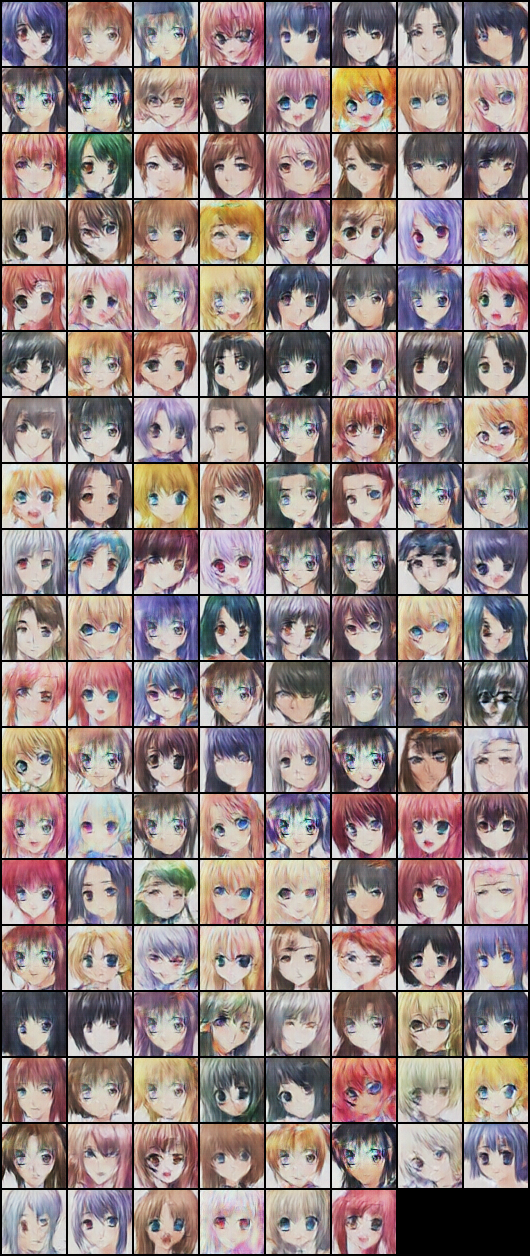

In [22]:
from IPython.display import Image
Image('./Generated/Generated-images-0041.png')

In [61]:
vec =torch.randn(150,latent_size,1,1)

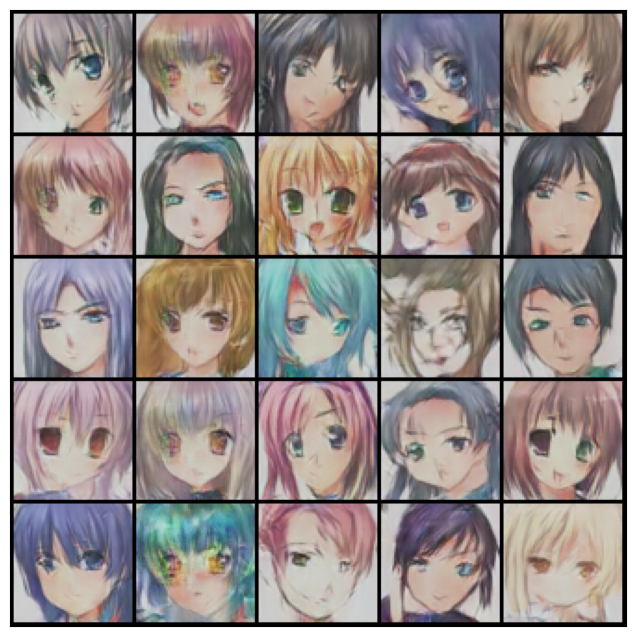

In [63]:
vec = to_device(vec, device)
Image = generator(vec)
Image = to_device(Image,'cpu')
show_images(Image)